Using CuPy (GPU acceleration)

parameters: dendrite_mask: 7360.0, dendrite_b: 230, soma_W: 230.0, soma_b: 10
number of model_1 params: 7940

parameters: dendrite_mask: 7360.0, dendrite_b: 230, soma_W: 230.0, soma_b: 10
number of model_2 params: 7940
number of model_3 params: 8070
Loading MNIST dataset...
Training data shape: (60000, 784), (60000, 10)
Test data shape: (10000, 784), (10000, 10)
Training Synaptic Resampling model...


Training : 100%|█████████▉| 4680/4700 [00:10<00:00, 432.35it/s, Epoch=20/20, Batch=234/235, Loss=0.0820]


train accuracy Synaptic Resampling model 96.8%
test accuracy Synaptic Resampling model 96.1%
Training Base Dendritic model...


Training : 100%|█████████▉| 4680/4700 [00:10<00:00, 440.97it/s, Epoch=20/20, Batch=234/235, Loss=0.0663]


Training Vanilla ANN model...


Training : 100%|█████████▉| 4680/4700 [00:08<00:00, 546.54it/s, Epoch=20/20, Batch=234/235, Loss=0.2167]


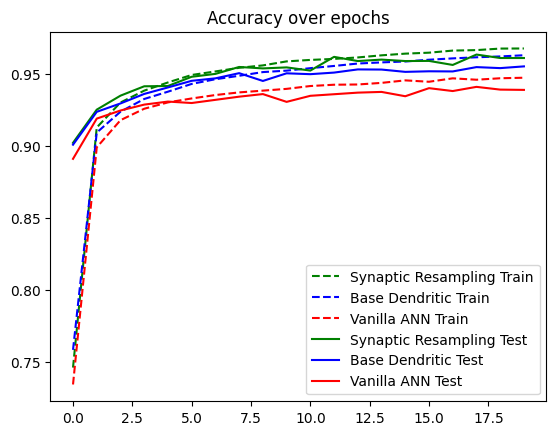

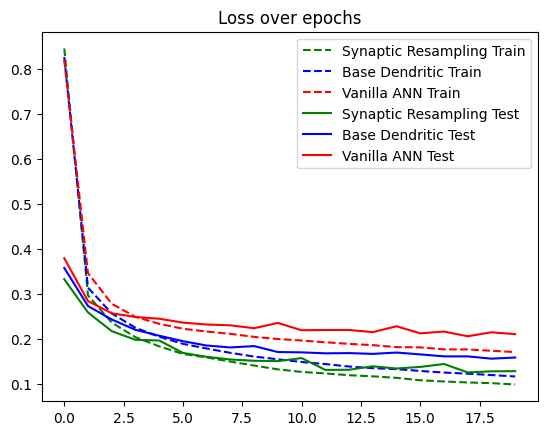

train loss Synaptic Resampling model 0.0989 vs Base Dendritic 0.1167 vs Vanilla ANN 0.1709
test loss Synaptic Resampling model 0.1285 vs Base Dendritic 0.1588 vs Vanilla ANN 0.2107
train accuracy Synaptic Resampling model 96.8% vs Base Dendritic 96.3% vs Vanilla ANN 94.7%
test accuracy Synaptic Resampling model 96.1% vs Base Dendritic 95.5% vs Vanilla ANN 93.9%


In [ ]:
try:
    import cupy as cp

    # Test if CuPy can actually access CUDA and random number generator
    cp.cuda.Device(0).compute_capability
    cp.random.seed(1)  # Test if random number generator works
    print("Using CuPy (GPU acceleration)")
except (ImportError, Exception) as e:
    import numpy as cp

    print(f"CuPy not available or CUDA error ({type(e).__name__}), using NumPy (CPU)")
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm


class CrossEntropy:
    def __init__(self):
        self.softmax_output = None
        self.target = None
        self.batch_size = None

    def forward(self, logits, target):
        # Handle both single samples and batches
        if logits.ndim == 1:
            # Single sample case - reshape to batch of size 1
            logits = logits.reshape(1, -1)
            target = target.reshape(1, -1)

        # Apply softmax per sample (along axis=1)
        # Subtract max for numerical stability, then exponentiate
        exp_logits = cp.exp(logits - cp.max(logits, axis=1, keepdims=True))
        # Divide by sum of exponentiated logits per sample (along axis=1)
        self.softmax_output = exp_logits / cp.sum(exp_logits, axis=1, keepdims=True)

        self.target = target
        self.batch_size = logits.shape[0]  # Store batch size

        # Compute cross entropy loss per sample, then average over the batch
        # Use a small epsilon for numerical stability with log(0)
        log_softmax = cp.log(self.softmax_output + 1e-15)
        # Only consider the log-probabilities of the true classes
        loss_per_sample = -cp.sum(
            target * log_softmax, axis=1
        )  # Sum over classes for each sample

        # Return the average loss over the batch
        return cp.mean(loss_per_sample)

    def backward(self):
        grad = (self.softmax_output - self.target) / self.batch_size
        return grad

    def __call__(self, logits, target):
        return self.forward(logits, target)


class LeakyReLU:
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        self.input = None

    def forward(self, x):
        self.input = x
        return cp.where(x > 0, x, self.alpha * x)

    def backward(self, grad):
        return cp.where(self.input > 0, grad, self.alpha * grad)

    def __call__(self, x):
        return self.forward(x)


class Adam:
    def __init__(
        self,
        params,
        lr=0.01,
        beta1=0.9,
        beta2=0.999,
        eps=1e-8,
    ):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0  # Global time step, increments once per batch

        # Initialize moment estimates based on layer type
        self.m = []
        self.v = []
        for layer in self.params:
            if hasattr(layer, "dendrite_W"):  # DendriticLayer
                self.m.append(
                    [
                        cp.zeros_like(layer.dendrite_W),
                        cp.zeros_like(layer.dendrite_b),
                        cp.zeros_like(layer.soma_W),
                        cp.zeros_like(layer.soma_b),
                    ]
                )
                self.v.append(
                    [
                        cp.zeros_like(layer.dendrite_W),
                        cp.zeros_like(layer.dendrite_b),
                        cp.zeros_like(layer.soma_W),
                        cp.zeros_like(layer.soma_b),
                    ]
                )
            else:  # LinearLayer
                self.m.append([cp.zeros_like(layer.W), cp.zeros_like(layer.b)])
                self.v.append([cp.zeros_like(layer.W), cp.zeros_like(layer.b)])

    def zero_grad(self):
        for layer in self.params:
            if hasattr(layer, "dendrite_W"):  # DendriticLayer
                layer.dendrite_dW = 0.0
                layer.dendrite_db = 0.0
                layer.soma_dW = 0.0
                layer.soma_db = 0.0
            else:  # LinearLayer
                layer.dW = 0.0
                layer.db = 0.0

    def step(self):
        self.t += 1  # Increment global time step
        for i, layer in enumerate(self.params):
            if hasattr(layer, "dendrite_W"):  # DendriticLayer
                grads = [
                    layer.dendrite_dW,
                    layer.dendrite_db,
                    layer.soma_dW,
                    layer.soma_db,
                ]
                params = [
                    layer.dendrite_W,
                    layer.dendrite_b,
                    layer.soma_W,
                    layer.soma_b,
                ]
            else:  # LinearLayer
                grads = [layer.dW, layer.db]
                params = [layer.W, layer.b]

            # Update moment estimates and parameters for each parameter
            for j, (grad, param) in enumerate(zip(grads, params)):
                # Update first moment estimate
                self.m[i][j] = self.beta1 * self.m[i][j] + (1 - self.beta1) * grad
                # Update second moment estimate
                self.v[i][j] = self.beta2 * self.v[i][j] + (1 - self.beta2) * (grad**2)

                # Bias correction
                m_hat = self.m[i][j] / (1 - self.beta1**self.t)
                v_hat = self.v[i][j] / (1 - self.beta2**self.t)

                # Update parameters
                param -= self.lr * m_hat / (cp.sqrt(v_hat) + self.eps)

    def __call__(self):
        return self.step()


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def params(self):
        """Return a list of layers that have a Weight vectors"""
        params = []
        for layer in self.layers:
            if hasattr(layer, "W") or hasattr(layer, "soma_W"):
                params.append(layer)
        return params

    def num_params(self):
        num_params = 0
        for layer in self.layers:
            if hasattr(layer, "num_params"):
                num_params += layer.num_params()
        return num_params

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class LinearLayer:
    """A fully connected, feed forward layer"""

    def __init__(self, in_dim, out_dim):
        self.W = cp.random.randn(out_dim, in_dim) * cp.sqrt(
            2.0 / (in_dim)
        )  # He init, for ReLU
        self.b = cp.zeros(out_dim)
        self.dW = 0.0
        self.db = 0.0
        self.x = None

    def forward(self, x):
        self.x = x
        return x @ self.W.T + self.b

    def backward(self, grad):
        self.dW = grad.T @ self.x
        self.db = grad.sum(axis=0)
        grad = grad @ self.W
        return grad

    def num_params(self):
        return self.W.size + self.b.size

    def __call__(self, x):
        return self.forward(x)


class DendriticLayer:
    """A sparse dendritic layer, consiting of dendrites and somas"""

    def __init__(
        self,
        in_dim,
        n_neurons,
        n_dendrite_inputs,
        n_dendrites,
        synaptic_resampling=True,
        percentage_resample=0.25,
        steps_to_resample=128,
    ):
        self.in_dim = in_dim
        self.n_dendrite_inputs = n_dendrite_inputs
        self.n_neurons = n_neurons
        self.n_dendrites = n_dendrites
        self.n_soma_connections = n_dendrites * n_neurons
        self.n_synaptic_connections = n_dendrite_inputs * n_dendrites * n_neurons

        # dynamicly resample
        self.synaptic_resampling = synaptic_resampling
        self.percentage_resample = percentage_resample
        self.steps_to_resample = steps_to_resample
        # to keep track of resampling
        self.num_mask_updates = 1
        self.update_steps = 0

        self.dendrite_W = cp.random.randn(self.n_soma_connections, in_dim) * cp.sqrt(
            2.0 / (in_dim)
        )  # He init, for ReLU
        self.dendrite_b = cp.zeros((self.n_soma_connections))
        self.dendrite_dW = 0.0
        self.dendrite_db = 0.0
        self.dendrite_activation = LeakyReLU()

        self.soma_W = cp.random.randn(n_neurons, self.n_soma_connections) * cp.sqrt(
            2.0 / (self.n_soma_connections)
        )  # He init, for ReLU
        self.soma_b = cp.zeros(n_neurons)
        self.soma_dW = 0.0
        self.soma_db = 0.0
        self.soma_activation = LeakyReLU()

        # inputs to save for backprop
        self.dendrite_x = None
        self.soma_x = None

        # sample soma mask:
        # [[1, 1, 0, 0]
        #  [0, 0, 1, 1]]
        # number of 1 per row is n_dendrites, rest 0. every column only has 1 entry
        # number of rows equals n_neurons, number of columns eqais n_soma_connections
        # it is a step pattern, so the first n_dendrites entries of the first row are one.
        self.soma_mask = cp.zeros((n_neurons, self.n_soma_connections))
        for i in range(n_neurons):
            start_idx = i * n_dendrites
            end_idx = start_idx + n_dendrites
            self.soma_mask[i, start_idx:end_idx] = 1

        # mask out unneeded weights, thus making weights sparse
        self.soma_W = self.soma_W * self.soma_mask

        # sample dendrite mask
        # for each dendrite sample n_dendrite_inputs from the input array
        self.dendrite_mask = cp.zeros((self.n_soma_connections, in_dim))
        for i in range(self.n_soma_connections):
            # sample without replacement from possible input for a given dendrite from the whole input
            input_idx = cp.random.choice(
                cp.arange(in_dim), size=n_dendrite_inputs, replace=False
            )
            self.dendrite_mask[i, input_idx] = 1

        # mask out unneeded weights, thus making weights sparse
        self.dendrite_W = self.dendrite_W * self.dendrite_mask

    def forward(self, x):
        # dendrites forward pass
        self.dendrite_x = x
        x = x @ self.dendrite_W.T + self.dendrite_b
        x = self.dendrite_activation(x)

        # soma forward pass
        self.soma_x = x
        x = x @ self.soma_W.T + self.soma_b
        x = self.soma_activation(x)
        return x

    def backward(self, grad):        
        grad = self.soma_activation.backward(grad)

        # soma back pass, multiply with mask to keep only valid gradients
        self.soma_dW = grad.T @ self.soma_x * self.soma_mask
        self.soma_db = grad.sum(axis=0)
        soma_grad = grad @ self.soma_W

        soma_grad = self.dendrite_activation.backward(soma_grad)

        # dendrite back pass
        self.dendrite_dW = soma_grad.T @ self.dendrite_x * self.dendrite_mask
        self.dendrite_db = soma_grad.sum(axis=0)
        dendrite_grad = soma_grad @ self.dendrite_W

        self.update_steps += 1
        
        # resample dendrites every steps_to_resample steps
        if self.synaptic_resampling and self.update_steps >= self.steps_to_resample:
            # reset step counter
            self.update_steps = 0
            self.resample_dendrites()

        return dendrite_grad

    def resample_dendrites(self):
        """
        Implements synaptic resampling by replacing weak dendritic connections with new random ones.
        
        This method mimics synaptic plasticity in biological neurons, where weak or unused 
        synaptic connections are pruned and replaced with new connections to explore different
        input patterns. The resampling helps prevent overfitting and maintains exploration
        capabilities during training.
        
        Algorithm Overview:
        1. **Connection Removal**: Identifies the weakest connections (lowest weight magnitude) 
           for removal based on `self.percentage_resample`
        2. **One-shot Resampling**: Randomly samples new input connections for each removed connection
        3. **Conflict Detection**: Checks for conflicts with existing connections and duplicate
           assignments within the same dendrite
        4. **Successful Swaps**: Applies only valid swaps that don't create conflicts
        5. **Verification**: Ensures the dendritic structure integrity is maintained
        
        The method operates efficiently by:
        - Using vectorized operations for all dendrites simultaneously
        - Implementing one-shot resampling rather than iterative attempts
        - Only applying successful swaps to avoid invalid states
        - Maintaining sparsity through the dendrite_mask
        
        Side Effects:
            - Updates self.dendrite_mask to reflect new connection patterns
            - Reinitializes weights for new connections using He initialization
            - Zeros out weights and gradients for removed connections
            - Increments self.num_mask_updates counter
        
        Raises:
            AssertionError: If resampling violates dendritic structure constraints
                - Each dendrite must maintain exactly n_dendrite_inputs connections
                - Total active connections must equal n_synaptic_connections
        
        Returns:
            None: Method modifies the layer's state in-place
            
        Note:
            - Called automatically during backward pass if synaptic_resampling=True
            - Early returns if percentage_resample results in 0 connections to remove
            - Biologically inspired by synaptic pruning and neuroplasticity
        """
        # --- Part 1: Connection Removal ---
        # calculate number of connections to remove per dendrite
        n_to_remove_per_dendrite = int(
            self.n_dendrite_inputs * self.percentage_resample
        )
        if n_to_remove_per_dendrite == 0: 
            return

        num_dendrites = self.dendrite_mask.shape[0]

        # The metric is the magnitude of the weights, removing the smallest.
        metric = cp.abs(self.dendrite_W)
        # Set inactive connections to infinity so they are not picked.
        metric[self.dendrite_mask == 0] = cp.inf
        # sort by magnitude
        sorted_indices = cp.argsort(metric, axis=1)
        # remove the smallest n_to_remove_per_dendrite connections per dendrite
        cols_to_remove = sorted_indices[:, :n_to_remove_per_dendrite]

        # Create corresponding row indices and flatten for the swap logic
        # dummy array of dendrite indices shape (num_dendrites, 1)
        rows_to_remove = cp.arange(num_dendrites)[:, cp.newaxis]
        # dummy array of shape (num_dendrites , n_to_remove_per_dendrite), flattened
        removed_dendrite_indices = rows_to_remove.repeat(n_to_remove_per_dendrite, axis=1).flatten()
        removed_input_indices = cols_to_remove.flatten()
        
        # removed_input_indices, contins the indices of the inputs to remove/resample
        # for each dendrite in a flattened array

        # --- Part 2: One-shot Resampling Attempt ---
        n_connections_to_resample = removed_dendrite_indices.size

        # sample n_connections_to_resample new inputs between 0 and in_dim
        newly_selected_input_indices = cp.random.randint(
            0, self.in_dim, size=n_connections_to_resample, dtype=int
        ) # shape (n_connections_to_resample, 1)
        
        # --- Part 3: Conflict Detection ---
        # check if new inputs are already existing in the same dendrite
        conflict_with_existing = (
            self.dendrite_mask[removed_dendrite_indices, newly_selected_input_indices]
            == 1
        )

        # create flat indices of proposed new connections
        # by multiplying dendrite index with in_dim and adding the input index,
        # we get a unique index for each proposed new connection, in  the same dendrite
        proposed_flat_indices = (
            removed_dendrite_indices * self.in_dim
            + newly_selected_input_indices
        ) # shape (n_connections_to_resample, 1)
        
        # count number of occurences of each index
        counts = cp.bincount(
            proposed_flat_indices.astype(int),
            minlength=num_dendrites * self.in_dim,
        ) # shape (num_dendrites * in_dim, 1)
        
        # check if index is duplicated, in the same dendrite
        is_duplicate_flat = counts[proposed_flat_indices.astype(int)] > 1
        
        # flag as problematic if either conflict or duplicate
        is_problematic = conflict_with_existing | is_duplicate_flat
        # flag as successful if not problematic
        is_successful = ~is_problematic

        # --- Part 4: Apply Successful Swaps ---
        dendrites_to_swap = removed_dendrite_indices[is_successful]

        # if no successful swaps, return
        if dendrites_to_swap.size == 0:
            return
        
        # get indices of old and new inputs to remove and add
        old_inputs_to_remove = removed_input_indices[is_successful]
        new_inputs_to_add = newly_selected_input_indices[is_successful]
        
        # Update mask: remove old connections and add new ones
        self.dendrite_mask[dendrites_to_swap, old_inputs_to_remove] = 0
        self.dendrite_mask[dendrites_to_swap, new_inputs_to_add] = 1

        # Initialize new weights with He initialization
        self.dendrite_W[dendrites_to_swap, new_inputs_to_add] = cp.random.randn(
            dendrites_to_swap.shape[0]
        ) * cp.sqrt(2.0 / self.in_dim)
        
        # Apply mask to ensure only active connections have non-zero weights
        self.dendrite_W = self.dendrite_W * self.dendrite_mask
        # Also zero out gradients for removed connections
        self.dendrite_dW = self.dendrite_dW * self.dendrite_mask

        # print(f"num of dendrite successful swaps: {dendrites_to_swap.size}")

        self.num_mask_updates += 1

        # --- Part 5: Verification ---
        n_dendritic_mask_connections = cp.sum(self.dendrite_mask, axis=1)
        assert cp.all(n_dendritic_mask_connections == self.n_dendrite_inputs), (
            f"Resampling failed: not all dendrites have {self.n_dendrite_inputs} connections per dendrite."
        )
        assert (
            cp.sum(cp.count_nonzero(self.dendrite_W)) == self.n_synaptic_connections
        ), (
            f"Resampling failed: not all dendrites have {self.n_synaptic_connections} connections in total."
        )
        
    def num_params(self):
        print(
            f"\nparameters: dendrite_mask: {cp.sum(self.dendrite_mask)}, dendrite_b: {self.dendrite_b.size}, soma_W: {cp.sum(self.soma_mask)}, soma_b: {self.soma_b.size}"
        )
        return int(
            cp.sum(self.dendrite_mask)
            + self.dendrite_b.size
            + cp.sum(self.soma_mask)
            + self.soma_b.size
        )

    def __call__(self, x):
        return self.forward(x)


def load_mnist_data(
    dataset="mnist",
    subset_size=None,
):
    """
    Download and load the MNIST or Fashion-MNIST dataset.

    Args:
        dataset (str): Dataset to load - either "mnist" or "fashion-mnist"
        normalize (bool): If True, normalize pixel values to [0, 1]
        flatten (bool): If True, flatten 28x28 images to 784-dimensional vectors
        one_hot (bool): If True, convert labels to one-hot encoding
        subset_size (int): If specified, return only a subset of the data

    Returns:
        tuple: (X_train, y_train, X_test, y_test)
            X_train, X_test: Input features
            y_train, y_test: Target labels
    """
    # Map dataset names to OpenML dataset identifiers
    dataset_mapping = {"mnist": "mnist_784", "fashion-mnist": "Fashion-MNIST"}

    if dataset not in dataset_mapping:
        raise ValueError(
            f"Dataset must be one of {list(dataset_mapping.keys())}, got '{dataset}'"
        )

    dataset_name = dataset_mapping[dataset]
    print(f"Loading {dataset.upper()} dataset...")

    # Download dataset
    data = fetch_openml(
        dataset_name, version=1, as_frame=False, parser="auto", cache=True
    )

    X, y = data.data, data.target.astype(int)

    # Split into train and test (last 10k samples for test, rest for train)
    X_train, X_test = X[:60000], X[60000:]
    y_train, y_test = y[:60000], y[60000:]

    # Normalize pixel values and convert to GPU arrays
    # Convert to float32 first
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0

    # Calculate global mean and std from training data
    mean_val = X_train.mean()
    std_val = X_train.std()

    # Standardize to mean=0, std=1
    X_train = (X_train - mean_val) / std_val
    X_test = (X_test - mean_val) / std_val

    # Convert to CuPy arrays
    X_train = cp.array(X_train)
    X_test = cp.array(X_test)

    # Convert labels to one-hot encoding
    def to_one_hot(labels, n_classes=10):
        one_hot_labels = cp.zeros((len(labels), n_classes))
        one_hot_labels[cp.arange(len(labels)), labels] = 1
        return one_hot_labels

    y_train = to_one_hot(cp.array(y_train))
    y_test = to_one_hot(cp.array(y_test))

    # Use subset if specified
    if subset_size is not None:
        X_train, y_train = X_train[:subset_size], y_train[:subset_size]
        X_test, y_test = (
            X_test[: subset_size // 6],
            y_test[: subset_size // 6],
        )  # Keep proportional test size

    print(f"Training data shape: {X_train.shape}, {y_train.shape}")
    print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    return X_train, y_train, X_test, y_test


def create_batches(X, y, batch_size=128, shuffle=True, drop_last=False):
    n_samples = len(X)
    # shuffle data
    if shuffle:
        indices = cp.arange(n_samples)
        cp.random.shuffle(indices)
        X = X[indices]
        y = y[indices]

    for i in range(0, n_samples, batch_size):
        if drop_last and i + batch_size > n_samples:
            break
        X_batch = X[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield X_batch, y_batch


def train(
    X_train,
    y_train,
    X_test,
    y_test,
    model,
    criterion,
    optimiser,
    n_epochs=2,
    batch_size=128,
):
    train_losses = []
    accuracy = []
    test_losses = []
    test_accuracy = []
    n_samples = len(X_train)
    num_batches_per_epoch = (n_samples + batch_size - 1) // batch_size
    total_batches = n_epochs * num_batches_per_epoch

    with tqdm(total=total_batches, desc="Training ") as pbar:
        for epoch in range(n_epochs):
            train_loss = 0.0
            correct_pred = 0.0
            for batch_idx, (X, target) in enumerate(
                create_batches(
                    X_train, y_train, batch_size, shuffle=True, drop_last=True
                )
            ):
                # forward pass
                pred = model(X)
                batch_loss = criterion(pred, target)
                train_loss += batch_loss
                # if most likely prediction equals target add to correct predictions
                batch_correct = cp.sum(
                    cp.argmax(pred, axis=1) == cp.argmax(target, axis=1)
                )
                correct_pred += batch_correct

                # backward pass
                optimiser.zero_grad()
                grad = criterion.backward()
                model.backward(grad)
                optimiser.step()

                # Update progress bar
                pbar.set_postfix(
                    {
                        "Epoch": f"{epoch + 1}/{n_epochs}",
                        "Batch": f"{batch_idx + 1}/{num_batches_per_epoch}",
                        "Loss": f"{float(batch_loss):.4f}",
                    }
                )
                pbar.update(1)
            # evaluate on test set
            epoch_test_loss, epoch_test_accuracy = evaluate(
                X_test, y_test, model, criterion
            )
            normalised_train_loss = train_loss / num_batches_per_epoch
            train_losses.append(float(normalised_train_loss))
            epoch_accuracy = correct_pred / n_samples
            accuracy.append(float(epoch_accuracy))
            test_losses.append(float(epoch_test_loss))
            test_accuracy.append(float(epoch_test_accuracy))
    return train_losses, accuracy, test_losses, test_accuracy


def evaluate(
    X_test,
    y_test,
    model,
    criterion,
    batch_size=1024,  # higher batch size for testing
):
    n_samples = len(X_test)
    test_loss = 0.0
    correct_pred = 0.0
    num_batches_per_epoch = (n_samples + batch_size - 1) // batch_size
    for X, target in create_batches(X_test, y_test, batch_size, shuffle=False):
        # forward pass
        pred = model(X)
        batch_loss = criterion(pred, target)
        test_loss += batch_loss
        # if most likely prediction equals target add to correct predictions
        batch_correct = cp.sum(cp.argmax(pred, axis=1) == cp.argmax(target, axis=1))
        correct_pred += batch_correct
    normalised_test_loss = test_loss / num_batches_per_epoch
    accuracy = correct_pred / n_samples
    return float(normalised_test_loss), float(accuracy)


def plot_dendritic_weights_single_image(
    model, input_image, neuron_idx=0, image_shape=(28, 28)
):
    """
    Plots the aggregated magnitude of all dendritic weights of a single neuron on one image.
    Color indicates the sum of magnitudes at each location.
    """

    def to_numpy(arr):
        if hasattr(arr, "get"):
            return arr.get()
        return np.asarray(arr)

    # Find the first DendriticLayer
    dendritic_layer = None
    for layer in model.layers:
        if hasattr(layer, "dendrite_W"):
            dendritic_layer = layer
            break

    if dendritic_layer is None:
        print("No DendriticLayer found in the model.")
        return

    if not (0 <= neuron_idx < dendritic_layer.n_neurons):
        print(
            f"Invalid neuron_idx. Must be between 0 and {dendritic_layer.n_neurons - 1}."
        )
        return

    # Get the weights and mask for the specified neuron's dendrites
    start_idx = neuron_idx * dendritic_layer.n_dendrites
    end_idx = start_idx + dendritic_layer.n_dendrites

    dendrite_weights = to_numpy(dendritic_layer.dendrite_W[start_idx:end_idx])
    dendrite_mask = to_numpy(dendritic_layer.dendrite_mask[start_idx:end_idx])

    masked_weights = dendrite_weights * dendrite_mask
    input_image_np = to_numpy(input_image)

    # Calculate and sum magnitudes
    magnitudes = np.abs(masked_weights)
    summed_magnitudes = np.sum(magnitudes, axis=0)

    # Reshape for plotting
    summed_magnitudes_2d = summed_magnitudes.reshape(image_shape)

    # Plot background image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(input_image_np.reshape(image_shape), cmap="gray", interpolation="nearest")

    # Mask zeros for the overlay
    heatmap_masked = np.ma.masked_where(summed_magnitudes_2d == 0, summed_magnitudes_2d)

    # Plot heatmap of magnitudes
    im = ax.imshow(heatmap_masked, cmap="viridis", alpha=0.6, interpolation="nearest")

    # Add colorbar
    fig.colorbar(im, ax=ax, label="Sum of Weight Magnitudes")

    ax.set_title(f"Aggregated Dendritic Weight Magnitudes for Neuron {neuron_idx}")
    ax.axis("off")
    plt.tight_layout()
    plt.show()


def plot_dendritic_weights_full_model(model, image_shape=(28, 28)):
    """
    Plots the aggregated magnitude of all dendritic weights across all neurons in the model.
    Shows the combined weight pattern without any background image.
    """

    def to_numpy(arr):
        if hasattr(arr, "get"):
            return arr.get()
        return np.asarray(arr)

    # Find the DendriticLayer
    dendritic_layer = None
    for layer in model.layers:
        if hasattr(layer, "dendrite_W"):
            dendritic_layer = layer
            break

    if dendritic_layer is None:
        print("No DendriticLayer found in the model.")
        return

    n_neurons = dendritic_layer.n_neurons
    n_dendrites = dendritic_layer.n_dendrites

    print(f"Visualizing {n_neurons} neurons, {n_dendrites} dendrites each")

    # Get all dendritic weights and masks
    dendrite_weights = to_numpy(dendritic_layer.dendrite_W)
    dendrite_mask = to_numpy(dendritic_layer.dendrite_mask)

    # Apply mask to get only active weights
    masked_weights = dendrite_weights * dendrite_mask

    # Calculate magnitudes and sum across all dendrites and neurons
    magnitudes = np.abs(masked_weights)
    total_magnitudes = np.sum(magnitudes, axis=0)

    # Reshape for plotting
    total_magnitudes_2d = total_magnitudes.reshape(image_shape)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot heatmap of all dendritic weights
    im = ax.imshow(total_magnitudes_2d, cmap="viridis", interpolation="nearest")

    # Add colorbar
    fig.colorbar(im, ax=ax, label="Sum of All Dendritic Weight Magnitudes")

    ax.set_title(
        f"All Dendritic Weights Aggregated\nTotal Neurons: {n_neurons}, Dendrites per Neuron: {n_dendrites}"
    )
    ax.axis("off")
    plt.tight_layout()
    plt.show()

    # Also create a subplot showing individual neuron contributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle("Dendritic Weight Analysis - Full Model", fontsize=16)

    # Plot 1: All weights aggregated
    im1 = axes[0, 0].imshow(
        total_magnitudes_2d, cmap="viridis", interpolation="nearest"
    )
    axes[0, 0].set_title("All Dendritic Weights")
    axes[0, 0].axis("off")
    fig.colorbar(im1, ax=axes[0, 0], shrink=0.7)

    # Plot 2: Weight distribution histogram
    axes[0, 1].hist(
        magnitudes[magnitudes > 0], bins=50, alpha=0.7, color="blue", edgecolor="black"
    )
    axes[0, 1].set_title("Weight Magnitude Distribution")
    axes[0, 1].set_xlabel("Weight Magnitude")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Spatial activity map (sum of absolute weights at each location)
    spatial_activity = np.sum(np.abs(masked_weights), axis=0).reshape(image_shape)
    im3 = axes[1, 0].imshow(spatial_activity, cmap="plasma", interpolation="nearest")
    axes[1, 0].set_title("Spatial Activity Map")
    axes[1, 0].axis("off")
    fig.colorbar(im3, ax=axes[1, 0], shrink=0.7)

    # Plot 4: Active connections map (count of non-zero weights at each location)
    active_connections = np.sum(masked_weights != 0, axis=0).reshape(image_shape)
    im4 = axes[1, 1].imshow(active_connections, cmap="hot", interpolation="nearest")
    axes[1, 1].set_title("Active Connections Count")
    axes[1, 1].axis("off")
    fig.colorbar(im4, ax=axes[1, 1], shrink=0.5)

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"\n=== Full Model Dendritic Statistics ===")
    print(f"Total parameters: {dendrite_weights.size}")
    print(f"Active parameters: {np.sum(dendrite_mask)}")
    print(f"Sparsity: {1 - np.sum(dendrite_mask) / dendrite_mask.size:.4f}")
    print(f"Mean active weight magnitude: {np.mean(magnitudes[magnitudes > 0]):.6f}")
    print(f"Max weight magnitude: {np.max(magnitudes):.6f}")
    print(f"Min non-zero weight magnitude: {np.min(magnitudes[magnitudes > 0]):.6f}")


# for repoducability
cp.random.seed(1287305472311233)

# data config
dataset = "mnist"  # "mnist", "fashion-mnist"

# config
n_epochs = 20  # 15 MNIST, 20 Fashion-MNIST
lr = 0.002  # 0.002
v_lr = 0.002  # 0.002 
b_lr = 0.002  # 0.002
batch_size = 256

in_dim = 28 * 28  # Image dimensions (28x28 MNIST)
n_classes = 10

# dendritic model config
n_dendrite_inputs = 32  # 32
n_dendrites = 23  # 23
n_neurons = 10  # 10

# vanilla model config
hidden_dim = 10 # 10

model_name_1 = "Synaptic Resampling"
model_name_2 = "Base Dendritic"
model_name_3 = "Vanilla ANN"

criterion = CrossEntropy()

# new model with synaptic resampling
model_1 = Sequential(
    [
        DendriticLayer(
            in_dim,
            n_neurons,
            n_dendrite_inputs=n_dendrite_inputs,
            n_dendrites=n_dendrites,
            synaptic_resampling=True,
            percentage_resample=0.5, # 0.5
            steps_to_resample=128, # 128
        ),
        LeakyReLU(),
        LinearLayer(n_neurons, n_classes),
    ]
)
# baseline dendritic model without synaptic resampling
model_2 = Sequential(
    [
        DendriticLayer(
            in_dim,
            n_neurons,
            n_dendrite_inputs=n_dendrite_inputs,
            n_dendrites=n_dendrites,
            synaptic_resampling=False,
        ),
        LeakyReLU(),
        LinearLayer(n_neurons, n_classes),
    ]
)
# vanilla ANN model
model_3 = Sequential(
    [
        LinearLayer(in_dim, hidden_dim),
        LeakyReLU(),
        LinearLayer(hidden_dim, hidden_dim),
        LeakyReLU(),
        LinearLayer(hidden_dim, n_classes),
    ]
)
optimiser_1 = Adam(model_1.params(), lr=lr)
optimiser_2 = Adam(model_2.params(), lr=b_lr)
optimiser_3 = Adam(model_3.params(), lr=v_lr)

print(f"number of model_1 params: {model_1.num_params()}")
print(f"number of model_2 params: {model_2.num_params()}")
print(f"number of model_3 params: {model_3.num_params()}")

# load data
X_train, y_train, X_test, y_test = load_mnist_data(dataset=dataset)

print(f"Training {model_name_1} model...")
train_losses_1, train_accuracy_1, test_losses_1, test_accuracy_1 = train(
    X_train,
    y_train,
    X_test,
    y_test,
    model_1,
    criterion,
    optimiser_1,
    n_epochs,
    batch_size,
)
print(f"train accuracy {model_name_1} model {round(train_accuracy_1[-1] * 100, 1)}%")
print(f"test accuracy {model_name_1} model {round(test_accuracy_1[-1] * 100, 1)}%")

print(f"Training {model_name_2} model...")
train_losses_2, train_accuracy_2, test_losses_2, test_accuracy_2 = train(
    X_train,
    y_train,
    X_test,
    y_test,
    model_2,
    criterion,
    optimiser_2,
    n_epochs,
    batch_size,
)

print(f"Training {model_name_3} model...")
train_losses_3, train_accuracy_3, test_losses_3, test_accuracy_3 = train(
    X_train,
    y_train,
    X_test,
    y_test,
    model_3,
    criterion,
    optimiser_3,
    n_epochs,
    batch_size,
)

# plot accuracy of vanilla model vs dendritic model
plt.plot(train_accuracy_1, label=f"{model_name_1} Train", color="green", linestyle="--")
plt.plot(train_accuracy_2, label=f"{model_name_2} Train", color="blue", linestyle="--")
plt.plot(train_accuracy_3, label=f"{model_name_3} Train", color="red", linestyle="--")
plt.plot(test_accuracy_1, label=f"{model_name_1} Test", color="green")
plt.plot(test_accuracy_2, label=f"{model_name_2} Test", color="blue")
plt.plot(test_accuracy_3, label=f"{model_name_3} Test", color="red")
plt.title("Accuracy over epochs")
plt.legend()
plt.show()

# plot both models in comparison
plt.plot(train_losses_1, label=f"{model_name_1} Train", color="green", linestyle="--")
plt.plot(train_losses_2, label=f"{model_name_2} Train", color="blue", linestyle="--")
plt.plot(train_losses_3, label=f"{model_name_3} Train", color="red", linestyle="--")
plt.plot(test_losses_1, label=f"{model_name_1} Test", color="green")
plt.plot(test_losses_2, label=f"{model_name_2} Test", color="blue")
plt.plot(test_losses_3, label=f"{model_name_3} Test", color="red")
plt.title("Loss over epochs")
plt.legend()
plt.show()

print(
    f"train loss {model_name_1} model {round(train_losses_1[-1], 4)} vs {model_name_2} {round(train_losses_2[-1], 4)} vs {model_name_3} {round(train_losses_3[-1], 4)}"
)
print(
    f"test loss {model_name_1} model {round(test_losses_1[-1], 4)} vs {model_name_2} {round(test_losses_2[-1], 4)} vs {model_name_3} {round(test_losses_3[-1], 4)}"
)
print(
    f"train accuracy {model_name_1} model {round(train_accuracy_1[-1] * 100, 1)}% vs {model_name_2} {round(train_accuracy_2[-1] * 100, 1)}% vs {model_name_3} {round(train_accuracy_3[-1] * 100, 1)}%"
)
print(
    f"test accuracy {model_name_1} model {round(test_accuracy_1[-1] * 100, 1)}% vs {model_name_2} {round(test_accuracy_2[-1] * 100, 1)}% vs {model_name_3} {round(test_accuracy_3[-1] * 100, 1)}%"
)

Visualizing 10 neurons, 23 dendrites each


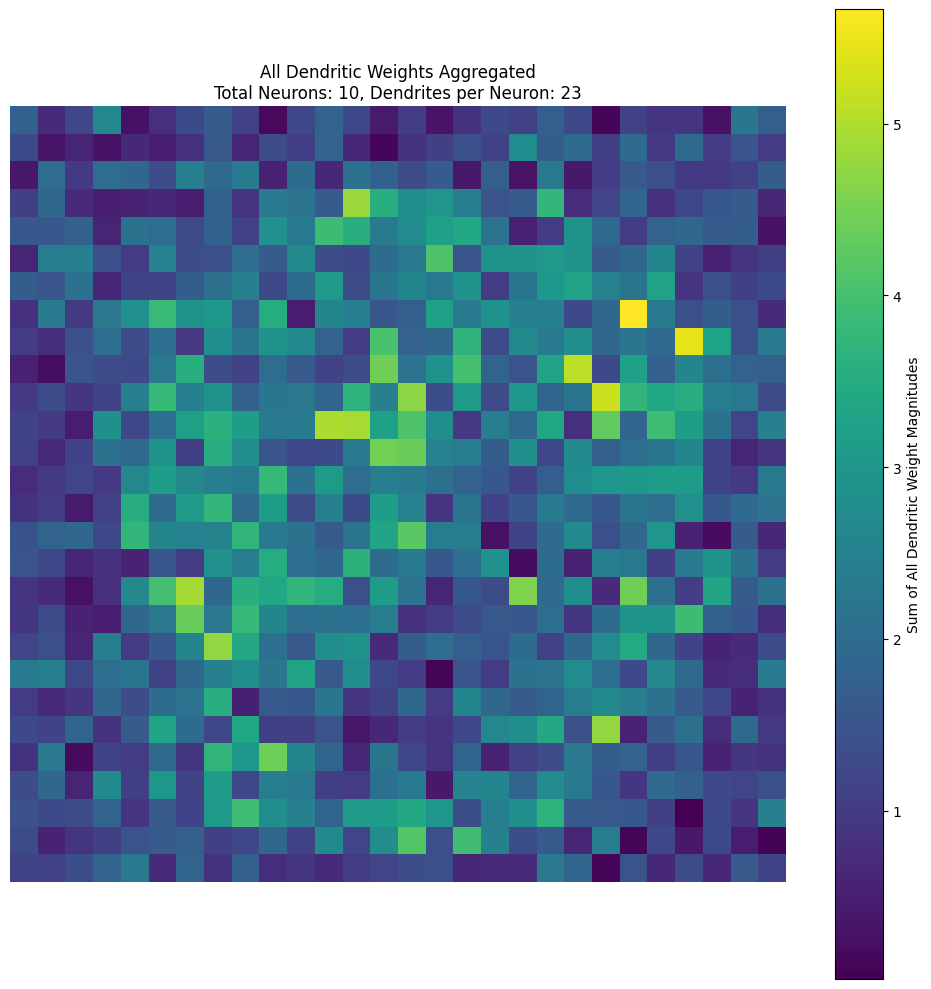

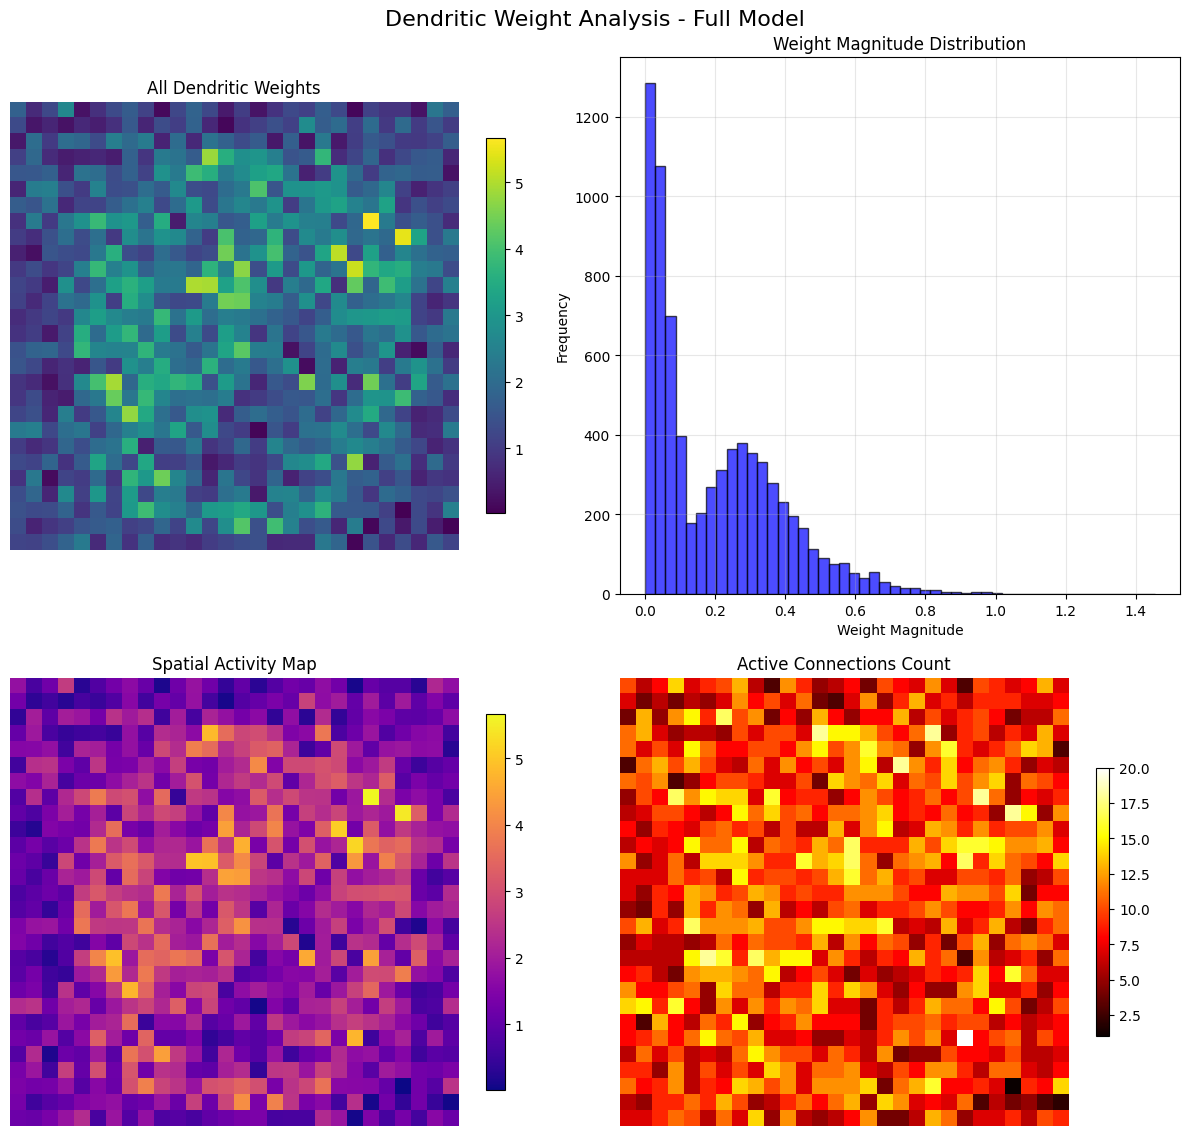


=== Full Model Dendritic Statistics ===
Total parameters: 180320
Active parameters: 7360.0
Sparsity: 0.9592
Mean active weight magnitude: 0.199849
Max weight magnitude: 1.453689
Min non-zero weight magnitude: 0.000031
Visualizing 10 neurons, 23 dendrites each


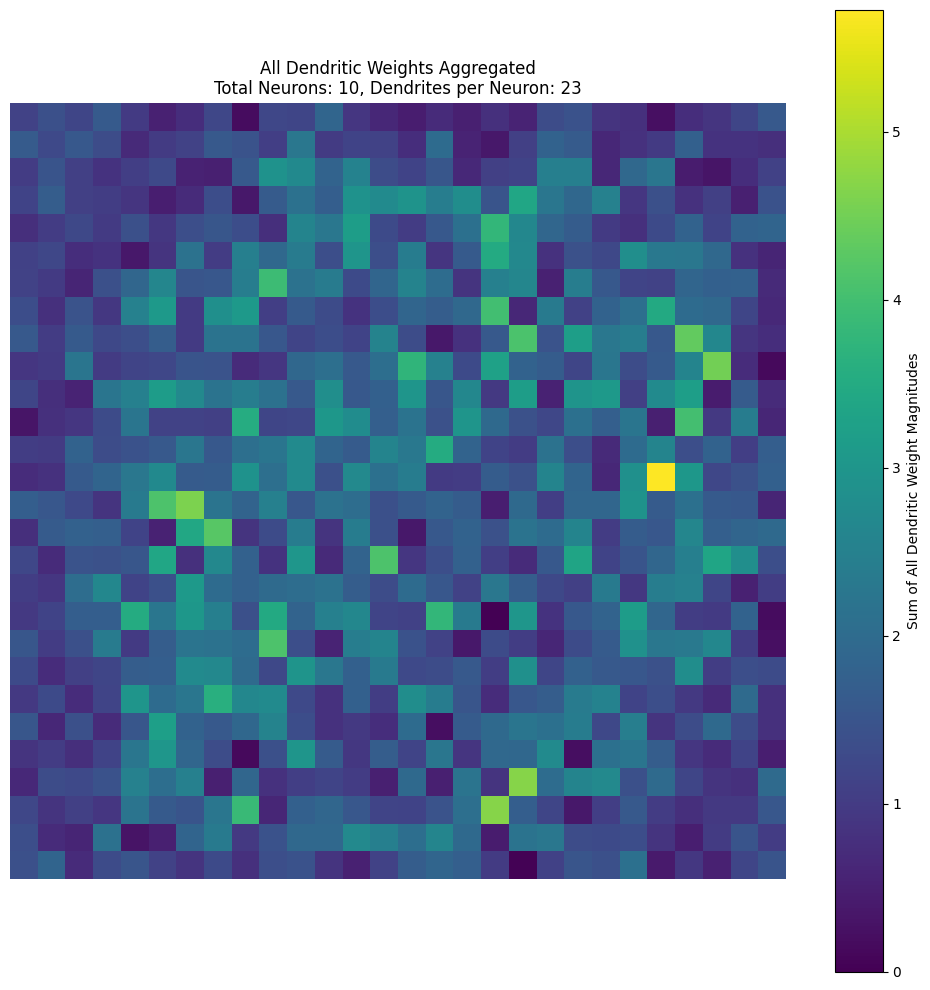

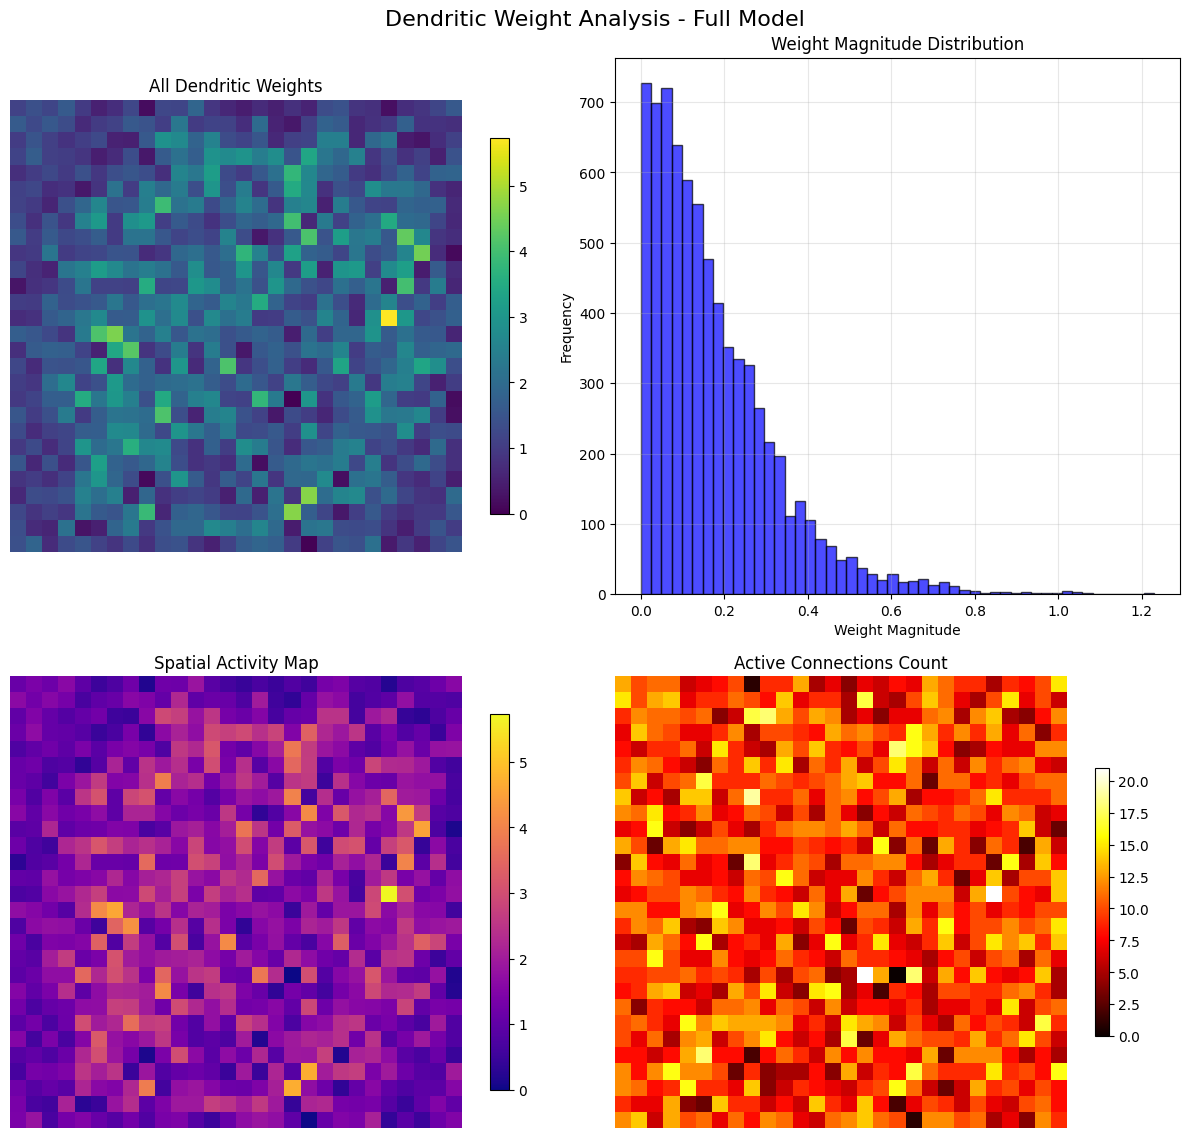


=== Full Model Dendritic Statistics ===
Total parameters: 180320
Active parameters: 7360.0
Sparsity: 0.9592
Mean active weight magnitude: 0.174495
Max weight magnitude: 1.230598
Min non-zero weight magnitude: 0.000010


In [ ]:
# plot_dendritic_weights_single_image(model_1, X_train[0], neuron_idx=4)
plot_dendritic_weights_full_model(model_1)
plot_dendritic_weights_full_model(model_2)